In [13]:

import os
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
# from torchvision.transforms import functional as F
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Own
from waste_dataset import WasteDatasetImages, SUPERCATEGORIES
from classifier.simpleCNN import SimpleClassifier
from classifier.train_classifier import train


In [2]:
DATA_PATH = "/dtu/datasets1/02514/data_wastedetection"
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def plot_images(dataloader):    # save image with bboxes
    num_images_to_process = 10
    for idx, (image, bboxes) in enumerate(dataloader):
        if idx >= num_images_to_process:
            break

        img = image.squeeze().permute(1, 2, 0).numpy()

        fig, ax = plt.subplots()
        ax.imshow(img)

        for bbox in bboxes:
            bbox = [item.item() for item in bbox]
            x, y, width, height = bbox
            rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        output_path = os.path.join(output_dir, f"image_{idx}.jpg")
        plt.savefig(output_path)
        plt.close(fig)

        print(f"Processed image {idx + 1}/{len(dataloader)}")

    print("Images with bounding boxes saved.")

def plot_images_jupyter(images_og, image_idx, train_proposals, train_label, num_images = 8):
    def_colors = ["red", "blue", "orange", "purple", "cyan", "pink", "olive", "yellow", "navy"]
    num_images   = num_images
    counter      = 0
    prev_img_idx = image_idx[0]
    for idx in range(num_images):
        fig, ax = plt.subplots()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(images_og[idx])
        has_label = set()
        while True:
            if counter+1 == len(train_label) or image_idx[counter] != prev_img_idx:
                prev_img_idx = image_idx[counter]
                break
            lab = train_label[counter]
            x, y, width, height = train_proposals[counter]
            rect = patches.Rectangle((x, y), width, height, linewidth=min(3,2*lab+1), edgecolor=def_colors[lab], 
                                     facecolor='none', label = SUPERCATEGORIES[lab] if lab not in has_label else "")
            ax.add_patch(rect)
            has_label.add(lab)
            counter += 1
        ax.legend()
        fig.savefig(f"../../../output_images/Patch_{idx}.png")

def draw_bboxes(image, bboxes, labels, index):
    fig, ax = plt.subplots()

    ax.imshow(image)

    for bbox, label in zip(bboxes, labels):
        x, y, width, height = bbox
        rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor='r' if label == 1 else 'b', facecolor='none')
        ax.add_patch(rect)

    if not os.path.exists("inference"):
        os.makedirs("inference")

    plt.axis('off')
    plt.savefig(f'inference/(bbox_visualization_on_test_images_{index}.png')
    plt.close(fig)



def visualize_bboxes(image, proposals, ground_truth_bboxes, iou_scores):
    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox in ground_truth_bboxes:
        bbox_x, bbox_y, bbox_w, bbox_h = bbox
        rect = patches.Rectangle((bbox_x, bbox_y), bbox_w, bbox_h,
                                 linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for proposal, iou_score in zip(proposals, iou_scores):
        proposal_x, proposal_y, proposal_w, proposal_h = proposal

        if iou_score > 0.2:
            rect = patches.Rectangle((proposal_x, proposal_y), proposal_w, proposal_h,
                                 linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

            ax.text(proposal_x, proposal_y, f"IOU: {float(iou_score):.2f}", color='r')

    plt.axis('off')
    plt.savefig('bbox_visualization.png')
    plt.close(fig)
    

def extract_color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])

    hist = cv2.normalize(hist, hist).flatten()

    return hist


def generate_proposals_and_labels(dataloader, ss, num_images_to_process, max_proposals_per_image, img_shape = (224,224)):
    data_list           = []
    images              = []
    resized_images      = []
    proposals_box_list  = []
    proposals_labels    = []
    image_idx           = []
    
    counter = 0

    for image, gt_bboxes, gt_label in tqdm(dataloader, desc=f"Processing images",total=num_images_to_process, leave=True):
        if counter >= num_images_to_process:
            break

        img = image.squeeze().permute(1, 2, 0).numpy()
        images.append(img)
        
        # selective search
        ss.setBaseImage(img)
        # ss.switchToSelectiveSearchQuality() #Maybe try with fast
        ss.switchToSelectiveSearchFast()
        rects = ss.process()

        proposal_bbox   = []
        proposal_image  = []

        for i, rect in enumerate(rects): # loop for each region in image
            if i >= max_proposals_per_image: 
                break
            x, y, width, height = rect
            bbox = [int(x), int(y), int(width), int(height)]
            proposal_bbox.append(bbox)
            
            proposal_img = img[y:y+height, x:x+width]
            proposal_img = cv2.resize(proposal_img, img_shape)
            proposal_img = np.transpose(proposal_img, [2,0,1]) # Rearrange axis
            proposal_image.append(proposal_img)

        labels = assign_labels(proposal_bbox, gt_bboxes, gt_label, image)
        
        # Remove gray-zones (inbetween threshold)
        for i, label in reversed(list(enumerate(labels))):
            if label == -1:
                del labels[i]
                del proposal_bbox[i]
                del proposal_image[i]
        # assert len(proposal_bbox) != 0, proposal_bbox
        
        # Limit background patches, ratio 8 to 1 non background 
        num_non_bg = len(labels) - labels.count(0)
        num_bg     = labels.count(0)
        limit_bg   = num_non_bg*3
        if limit_bg < num_bg: # Too many backgrounds
            transfer_labels = []
            transfer_bboxes = []
            transfer_images = []
            for idx in range(len(labels)):
                if labels[idx] == 0 and limit_bg == 0:
                    continue
                elif labels[idx] == 0:                  
                    limit_bg -= 1
                transfer_labels.append(        labels[idx])
                transfer_bboxes.append( proposal_bbox[idx])
                transfer_images.append(proposal_image[idx])
            labels          = transfer_labels
            proposal_bbox   = transfer_bboxes
            proposal_image  = transfer_images
        
        # # Adding ground truth     # Err0r: gt-bbox may be too small due to transforming, resulting in proposal_img = None 
        # for idx in range(len(gt_label)):
        #     labels.append(int(gt_label[idx]))
        #     x, y, width, height = int(gt_bboxes[idx][0]), int(gt_bboxes[idx][1]), int(gt_bboxes[idx][2]), int(gt_bboxes[idx][3]) 
        #     bbox = [x, y, width, height]
        #     proposal_bbox.append(bbox)
        #     proposal_img = img[y:y+height, x:x+width]
        #     proposal_img = cv2.resize(proposal_img, img_shape)
        #     proposal_img = np.transpose(proposal_img, [2,0,1])
        #     proposal_image.append(proposal_img)   
        
        # Extend
        proposals_box_list.extend(proposal_bbox)
        resized_images.extend(proposal_image)
        proposals_labels.extend(labels)
        data_list.extend(list(zip(proposal_bbox, labels)))
        image_idx.extend([counter]*len(labels))
        assert len(proposal_bbox) != 0, proposal_bbox#########################################

        counter += 1
        
    images = torch.tensor(images)
    return data_list, proposals_box_list, resized_images, proposals_labels, images, image_idx

def assign_labels(proposals_bbox, gt_bboxes, gt_label, image, iou_threshold1=0.3, iou_threshold2=0.7): # 
    labels = []
    iou_scores = []
    
    max_iou_failsafe        = -1    # In case of no positive, use the best 
    max_iou_failsafe_info   = None  #/
    image = image.squeeze().permute(1, 2, 0).numpy()
    
    for proposal in proposals_bbox:
        proposal_x1, proposal_y1, proposal_w, proposal_h = proposal
        proposal_area = proposal_w * proposal_h

        max_iou         = -1 # Initialize max IOU score for each proposal
        max_label_idx   = -1

        for idx, bbox in enumerate(gt_bboxes):
            bbox_x1, bbox_y1, bbox_w, bbox_h = bbox

            # Compare boxes
            intersection_x1 = max(proposal_x1, bbox_x1)
            intersection_y1 = max(proposal_y1, bbox_y1)
            intersection_x2 = min(proposal_x1 + proposal_w, bbox_x1 + bbox_w)
            intersection_y2 = min(proposal_y1 + proposal_h, bbox_y1 + bbox_h)

            intersection_area = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)
            bbox_area = bbox_w * bbox_h
            union_area = proposal_area + bbox_area - intersection_area

            iou = intersection_area / union_area
            iou_scores.append(iou)

            # Get closest matching box 
            if iou > max_iou:
                max_iou         = iou
                max_label_idx   = idx
            #
            if iou > max_iou_failsafe:
                max_iou_failsafe        = iou
                max_iou_failsafe_info   = (proposal, idx)
            
        if   max_iou <= iou_threshold1: labels.append(0)                            # Object proposal is a negative example
        elif max_iou >= iou_threshold2: labels.append(int(gt_label[max_label_idx])) # Object proposal is a positive example
        else:                           labels.append(-1)                           # Object proposal is not considered

    if labels.count(0)+labels.count(-1) == len(labels):
        idx         = proposals_bbox.index(max_iou_failsafe_info[0])
        labels[idx] = int(gt_label[max_iou_failsafe_info[1]])
    # num_ones = len(labels)
    # print(f"Number of objects: {num_ones}")

    # To visualize the bounding boxes and IOU scores, uncomment the following line
    #visualize_bboxes(image, proposals, bboxes, iou_scores)
    return labels


Total number of categories: 8
Generating proposals and labels for train set


Processing images: 100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


Exception: 

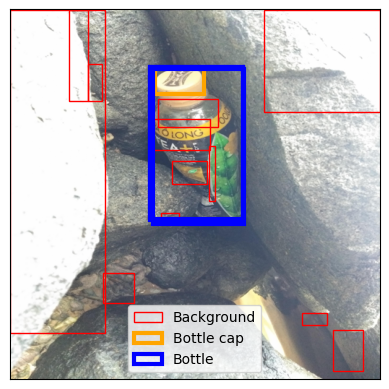

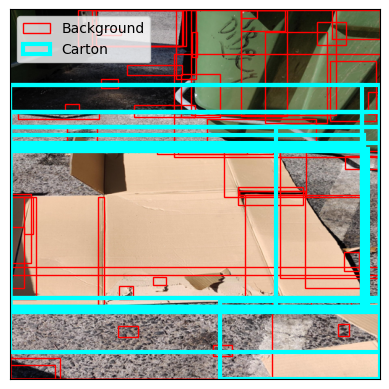

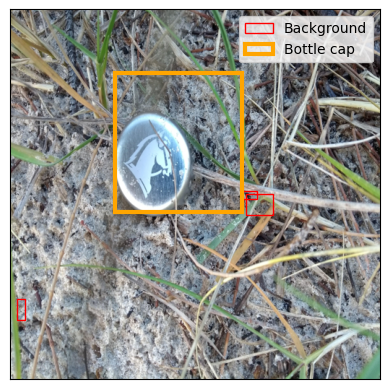

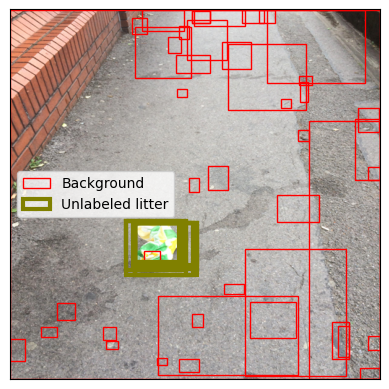

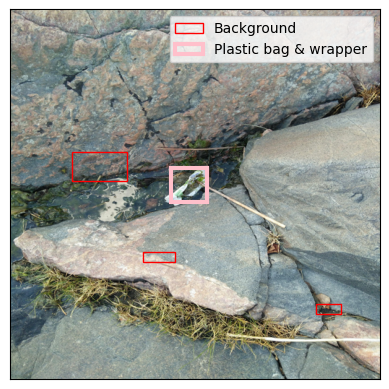

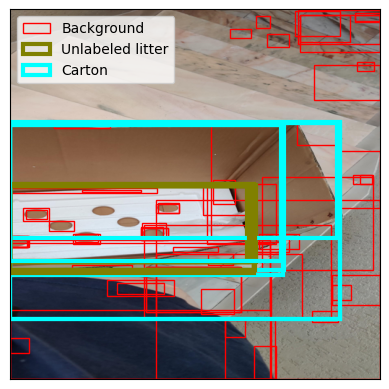

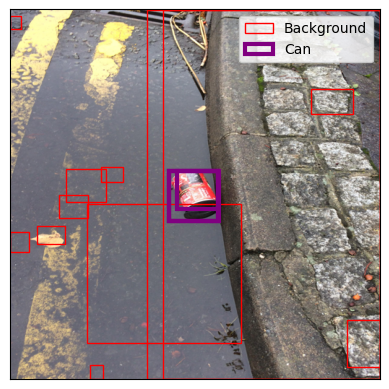

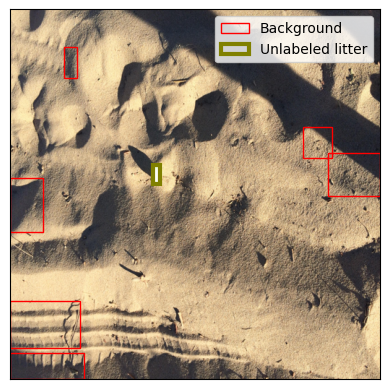

In [25]:
# Main
# ctest = 0
# ctrain = 0
patch_size = (128,128)
batch_size = 100

dataset = WasteDatasetImages(transform=transforms.ToTensor(), resize=(512,512))
num_classes = dataset.num_categories()
print(f"Total number of categories: {num_classes}")

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

num_images_to_process_train = len(train_dataset) #Amount of train images to process
num_images_to_process_test = len(test_dataset) #Amount of test images to process
max_proposals_per_image = 1000 # Selective search will generate max 1000 proposals per image
### Quick limit for debugging/testing
num_images_to_process_train = 8 #Amount of train images to process
num_images_to_process_test = 2 #Amount of test images to process

# Create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Run selective search 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

print("Generating proposals and labels for train set")
train_data, train_proposals, train_proposals_image, train_label, images_og, image_idx = generate_proposals_and_labels(train_dataloader, ss, num_images_to_process_train, max_proposals_per_image, img_shape=patch_size)
plot_images_jupyter(images_og, image_idx, train_proposals, train_label) # Plot with labels
raise Exception()

# Extract the features and their corresponding bounding boxes
# train_features_flat, train_boxes = zip(*[(feature, bbox) for bbox, feature in train_features])
# train_features_flat = list(train_features_flat)
# train_boxes = list(train_boxes)

# train_labels = [label for _, label in train_data]
# train_labels = np.array(train_labels)

train_size = int(0.75*len(train_proposals_image))
test_size = int(0.15*len(train_proposals_image))
val_size = len(train_proposals_image) - train_size - test_size 

train_ds, test_ds, val_ds = random_split(list(zip(train_proposals_image,train_label)), [train_size, test_size, val_size])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True )
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

# Load model
print("Loading Simple classifier model")
network = SimpleClassifier(num_classes, resolution=patch_size[0])
network.to(device)

network = SimpleClassifier(num_classes=num_classes, resolution=patch_size)
network.to(device)
learning_rate = 0.01
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
loss = F.cross_entropy
train(network, optimizer, 25, loss, train_dl, test_dl, val_dl, len(train_ds))


# print("Training done")
# print("Saving model")
# if not os.path.exists("models"):
#     os.makedirs("models")
# dump(svm, 'models/svm_model.joblib')


In [ ]:
# print("Generating proposals and labels for test set")
# test_data, test_proposals, test_image, test_label = generate_proposals_and_labels(test_dataloader, ss, num_images_to_process_test, max_proposals_per_image)

# # Extract the features and their corresponding bounding boxes
# test_features_flat, test_boxes = zip(*[(feature, bbox) for bbox, feature in test_features])
# test_features_flat = list(test_features_flat)
# test_boxes = list(test_boxes)

# test_labels = [label for _, label in test_data]
# test_labels = np.array(test_labels)

# # svm = load('models/svm_model.joblib')

# # Make predictions on the test data
# # predictions = svm.predict(test_features_flat)

# accuracy = accuracy_score(test_labels, predictions)
# precision = precision_score(test_labels, predictions)
# recall = recall_score(test_labels, predictions)
# f1 = f1_score(test_labels, predictions)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

# number_of_images = 20 #Test images to visualize

# for i, img in enumerate(test_images[:number_of_images]):
#     # features_per_image = test_features_per_image[i]

#     predictions_by_image = []
#     bbox_list_by_image = []

#     # for feature in features_per_image:
#     #     bbox, feature_hist = feature 
#     #     prediction = svm.predict([feature_hist])[0] 
#     #     predictions_by_image.append(prediction)
#     #     bbox_list_by_image.append(bbox)

#     object_indices = [j for j, pred in enumerate(predictions_by_image) if pred == 1]            
#     object_bboxes = [bbox_list_by_image[index] for index in object_indices]
#     draw_bboxes(img, object_bboxes, [1] * len(object_bboxes), i)